# Predictive models to identify high risk of churn customers in Telecom Industry

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

from sklearn.utils import resample

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the csv file and getting info of number of columns and rows
df = pd.read_csv('telecom_churn_data.csv')
print("Rows: ",df.shape[0])
print("Columns: ",df.shape[1])
df.head()

Rows:  99999
Columns:  226


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


## Data cleaning and Preparation

### Filtering high-value customers 

#### For this we need to find amount spend on data along with recharge amount in the first 2 months. After that we need to find customers who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months.

In [3]:
# Filling blank values as 0 for those customers who did not recharged in in 6th and 7th month

df.total_rech_data_6 = df.total_rech_data_6.fillna(0)
df.total_rech_data_7 = df.total_rech_data_7.fillna(0)
df.av_rech_amt_data_6 = df.av_rech_amt_data_6.fillna(0)
df.av_rech_amt_data_7 = df.av_rech_amt_data_7.fillna(0)

In [4]:
# Calculating the total amount of data recharge in 6th and 7th month

df['amt_rech_6'] = df.total_rech_data_6 * df.av_rech_amt_data_6
df['amt_rech_7'] = df.total_rech_data_7 * df.av_rech_amt_data_7

In [5]:
# Calculating the total amount spend by a customer

df['avg_amt_rech_6_7'] = (df.amt_rech_6 + df.total_rech_amt_6 + df.amt_rech_7 + df.total_rech_amt_7)/2

In [6]:
# Dropping the columns which were used to calculate the average amount of recharge

df = df.drop(['amt_rech_6', 'amt_rech_7', 'total_rech_data_6', 'total_rech_data_7', 'av_rech_amt_data_6', 'av_rech_amt_data_6'], axis=1)

In [7]:
# Filtering high valued customers

df1 = df[df.avg_amt_rech_6_7 >= df.avg_amt_rech_6_7.quantile(0.7)]

In [8]:
# Checking the number of rows or high valued customers

print("High valued customers are: ",df1.shape[0])

High valued customers are:  30001


### Data cleaning

In [9]:
# checking the columns with the null values and the count

with pd.option_context("display.max_rows", None):
    print(df1.isnull().sum()[df1.isnull().sum()>0].sort_values())

last_date_of_month_7           27
date_of_last_rech_6            73
date_of_last_rech_7            98
last_date_of_month_8          165
loc_og_t2o_mou                224
std_og_t2o_mou                224
loc_ic_t2o_mou                224
last_date_of_month_9          365
loc_og_t2m_mou_7              537
spl_ic_mou_7                  537
std_ic_t2t_mou_7              537
loc_og_t2f_mou_7              537
std_og_mou_7                  537
loc_og_t2c_mou_7              537
std_ic_mou_7                  537
loc_ic_t2m_mou_7              537
isd_og_mou_7                  537
loc_og_mou_7                  537
std_ic_t2o_mou_7              537
std_ic_t2m_mou_7              537
std_og_t2t_mou_7              537
std_og_t2f_mou_7              537
std_og_t2c_mou_7              537
std_og_t2m_mou_7              537
isd_ic_mou_7                  537
loc_ic_mou_7                  537
loc_ic_t2t_mou_7              537
onnet_mou_7                   537
loc_ic_t2f_mou_7              537
offnet_mou_7  

In [10]:
# Removing columns with single value as they don't have any usefull info

df2 = df1.drop(list(df1.nunique()[df1.nunique()==1].index),axis=1)

In [11]:
# Getting "churn" columns using 'vol_3g_mb_9', 'vol_2g_mb_9', 'total_og_mou_9'and 'total_ic_mou_9' columns

df2['churn'] = df2[['vol_3g_mb_9', 'vol_2g_mb_9', 'total_og_mou_9', 'total_ic_mou_9']].sum(axis=1)==0
df2["churn"] = df2["churn"].astype(int)

In [12]:
# Getting list of the columns that contain the data of 9th month i.e. last month

col_9 = [col for col in df2.columns if '_9' in col]
print(col_9)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9']


In [13]:
# Dropping the columns of the 9th month as in the practical problem we won't have last month data

df3 = df2.drop(col_9,axis=1)

In [14]:
total_rows = df3.shape[0]
df3.shape

(30001, 158)

In [15]:
# Remove columns with more than 30% empty data

with pd.option_context("display.max_rows", None):
    print(df3.isnull().sum()[df3.isnull().sum()/total_rows>0.3].sort_values())
df4 = df3.drop(list(df3.isnull().sum()[df3.isnull().sum()/total_rows>0.3].index),axis=1)

count_rech_2g_7             12944
date_of_last_rech_data_7    12944
arpu_3g_7                   12944
fb_user_7                   12944
max_rech_data_7             12944
night_pck_user_7            12944
count_rech_3g_7             12944
arpu_2g_7                   12944
arpu_3g_6                   13245
count_rech_3g_6             13245
date_of_last_rech_data_6    13245
count_rech_2g_6             13245
max_rech_data_6             13245
fb_user_6                   13245
night_pck_user_6            13245
arpu_2g_6                   13245
arpu_2g_8                   14048
night_pck_user_8            14048
count_rech_3g_8             14048
av_rech_amt_data_8          14048
count_rech_2g_8             14048
max_rech_data_8             14048
total_rech_data_8           14048
date_of_last_rech_data_8    14048
arpu_3g_8                   14048
fb_user_8                   14048
dtype: int64


In [16]:
# Dropping Rows which contain null values 

with pd.option_context("display.max_rows", None):
    print(df4.isnull().sum()[df4.isnull().sum()>0].sort_values())
df5 = df4.dropna()

date_of_last_rech_6      73
date_of_last_rech_7      98
loc_ic_t2f_mou_7        537
std_og_t2f_mou_7        537
std_og_t2m_mou_7        537
isd_og_mou_7            537
std_ic_t2f_mou_7        537
std_og_t2t_mou_7        537
loc_og_mou_7            537
spl_og_mou_7            537
std_ic_mou_7            537
loc_og_t2c_mou_7        537
std_ic_t2t_mou_7        537
loc_og_t2f_mou_7        537
std_ic_t2m_mou_7        537
spl_ic_mou_7            537
og_others_7             537
std_og_mou_7            537
onnet_mou_7             537
loc_og_t2t_mou_7        537
loc_ic_t2t_mou_7        537
isd_ic_mou_7            537
roam_og_mou_7           537
loc_ic_mou_7            537
loc_og_t2m_mou_7        537
roam_ic_mou_7           537
loc_ic_t2m_mou_7        537
ic_others_7             537
offnet_mou_7            537
std_ic_t2m_mou_6        545
isd_og_mou_6            545
std_ic_t2t_mou_6        545
loc_ic_t2m_mou_6        545
og_others_6             545
loc_ic_t2t_mou_6        545
loc_ic_mou_6        

In [17]:
# Getting the shape of the data set after removing null values

df5.shape

(28163, 132)

0    26625
1     1538
Name: churn, dtype: int64


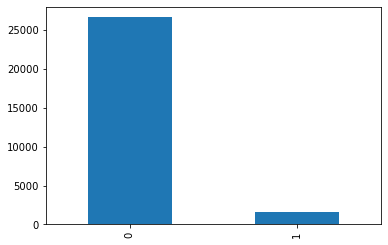

In [18]:
# Comparing the "churn" and "Not Churn" Values

df5.churn.value_counts().plot.bar()
print(df5.churn.value_counts())

## Here 0 is for "Not churn" and 1 is for "Churn"

In [19]:
# Checking the object type columns

object_col_data = df5.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6    6/27/2014
date_of_last_rech_7    7/25/2014
date_of_last_rech_8    8/26/2014
Name: 7, dtype: object


In [20]:
# We can remove these columns as they won't tell us any usefull info

df5 = df5.drop(['date_of_last_rech_8', 'date_of_last_rech_7', 'date_of_last_rech_6'], axis=1)

In [21]:
# Removing "mobile_number" columns as it won't tell us any usefull info

df5 = df5.drop(['mobile_number'],axis=1)


## Modeling

#### For this case study, Sensitivity is more important than accuracy as we need to focus on the customers who will churn

#### For modeling we are following these steps:
- Build simple logistic regression to get basic knowledge of the prediction accuracy and sensitivity
- Perform Resampling to solve the problem of class imbalance 
- Perform PCA to solve the problem of Overfitting and multi collinearity
- Build Decision Tree and see if the performance is increasing
- Build Random Forest and see if the performance is increasing
- Using Random Forest, find important features for churn

In [22]:
# Split in train & Test data set

train, test = train_test_split(df5, test_size=0.3, train_size=0.7, random_state=1)

In [23]:
# MinMax scaling training and testing data

scaler = MinMaxScaler().fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

train_df = pd.DataFrame(train_scaled, columns=train.columns)
test_df = pd.DataFrame(test_scaled, columns=train.columns)

In [24]:
# Splitting input and output columns

y_train = train_df.churn
X_train = train_df.drop(['churn'], axis=1)
y_test = test_df.churn
X_test = test_df.drop(['churn'], axis=1)

In [25]:
# Building simple logistic regression to get basic knowledge of the prediction accuracy and sensitivity

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [26]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [27]:
# Checking accuracy on the training and testing data

print("Accuracy on Training Data:",accuracy_score(y_train, y_train_pred))
print("Accuracy on Testing Data:",accuracy_score(y_test, y_test_pred))

Accuracy on Training Data: 0.9455209495789794
Accuracy on Testing Data: 0.9461474730737366


In [28]:
# Checking Recall or sensitivity on the training and testing data

print("Sensitivity on Training Data:",recall_score(y_train,y_train_pred))
print("Sensitivity on Testing Data:",recall_score(y_test,y_test_pred))

Sensitivity on Training Data: 0.04355885078776645
Sensitivity on Testing Data: 0.032679738562091505


### Accuracy is very high but sensitivity is very low because of class imbalance

#### We can use resampling to get equal number of rows for both classes

In [29]:
df_majority = train_df[train_df.churn==0]
df_minority = train_df[train_df.churn==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=18585,    # to match majority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.churn.value_counts()

0.0    18635
1.0    18585
Name: churn, dtype: int64

In [30]:
# Splitting input and output columns 

y_train_new = df_upsampled.churn
X_train_new = df_upsampled.drop(['churn'], axis=1)

In [31]:
# Performing PCA on training data

pca = PCA( random_state=100)
pca.fit(X_train_new)

PCA(random_state=100)

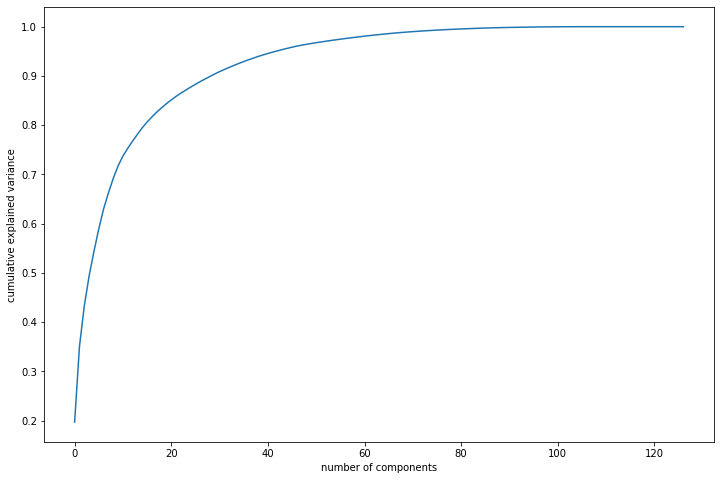

In [32]:
#Making the screeplot - plotting the cumulative variance against the number of components

%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [33]:
pca = PCA(n_components=30,random_state=100)
#Scale and transform data to get Principal Components

Xtrain_reduced = pca.fit_transform(X_train_new)
Xtest_reduced = pca.transform(X_test)
regrpca6 = LogisticRegression(random_state=0)
# Train the model using the principal components of the transformed training sets
regrpca6.fit(Xtrain_reduced, y_train_new)
y_train_pred = regrpca6.predict(Xtrain_reduced)
# Make predictions using the principal components of the transformed testing set
y_pred = regrpca6.predict(Xtest_reduced)

print("Training data Sensitivity: ",recall_score(y_train_new, y_train_pred))
print("Training data Accuracy: ",accuracy_score(y_train_new, y_train_pred))

print("Testing data Sensitivity: ",recall_score(y_test, y_pred))
print("Testing data Accuracy: ",accuracy_score(y_test, y_pred))


Training data Sensitivity:  0.8002690341673393
Training data Accuracy:  0.7936324556689952
Testing data Sensitivity:  0.7908496732026143
Testing data Accuracy:  0.7848266066990176


### In this instance we observe good sensitivity compared to the previous results, We can now try implementing Tree based models and see if we get better sensitivity

## Decision Tree using Grid search for Hyperparameters tuning

In [34]:
# Decision tree object for Grid search
dt = DecisionTreeClassifier(random_state=42)

# Parameters to tune
params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [50, 60, 70, 100],
    'criterion': ["entropy"]
}

In [35]:
# Instantiate the grid search model

grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "recall")

In [36]:
# Training the models
grid_search.fit(X_train_new, y_train_new)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [3, 4, 5, 6],
                         'min_samples_leaf': [50, 60, 70, 100]},
             scoring='recall', verbose=1)

In [37]:
# Getting the best model

dt_best = grid_search.best_estimator_

In [38]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train_new, dt_classifier.predict(X_train_new)))
    print("Train Recall :", recall_score(y_train_new, dt_classifier.predict(X_train_new)))
    print("Train Confusion Matrix:")
    confusion_train = confusion_matrix(y_train_new, dt_classifier.predict(X_train_new))
    print(confusion_train)
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Recall :", recall_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    confusion_test = confusion_matrix(y_test, dt_classifier.predict(X_test))
    print(confusion_test)

In [39]:
evaluate_model(dt_best)

Train Accuracy : 0.8466415905427189
Train Recall : 0.8299165994081248
Train Confusion Matrix:
[[16088  2547]
 [ 3161 15424]]
--------------------------------------------------
Test Accuracy : 0.854894070304178
Test Recall : 0.7450980392156863
Test Confusion Matrix:
[[6881 1109]
 [ 117  342]]


### We get better accuracy but almost same sensitivity as logistic regression

## Random Forest using Grid search for hyperparameters tuning

In [40]:
# Random Forest object for Grid search

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Parameters to tune
params = {
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [60, 70, 100],
    'max_features': [2,3,4],
    'n_estimators': [50, 100, 200]
}

In [41]:
# Instantiate the grid search model

grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "recall")

In [42]:
# Traing the models

grid_search.fit(X_train_new, y_train_new)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [60, 70, 100],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=1)

In [43]:
# Getting the best model

rf_best = grid_search.best_estimator_

In [49]:
evaluate_model(rf_best)

Train Accuracy : 0.8100483610961848
Train Recall : 0.7595372612321765
Train Confusion Matrix:
[[16034  2601]
 [ 4469 14116]]
--------------------------------------------------
Test Accuracy : 0.8448337081311398
Test Recall : 0.6623093681917211
Test Confusion Matrix:
[[6834 1156]
 [ 155  304]]


### We get better accuracy than the other 2 models but we dont have the desired sensitivity on the test set.

In [45]:
# Getting the most important features from the random forest

imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [46]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
80,total_ic_mou_8,0.056093
20,loc_og_t2m_mou_8,0.044479
65,loc_ic_mou_8,0.036833
56,loc_ic_t2t_mou_8,0.035191
11,roam_ic_mou_8,0.034893
...,...,...
42,isd_og_mou_6,0.000255
116,monthly_3g_7,0.000154
118,sachet_3g_6,0.000107
49,og_others_7,0.000000


In [47]:
# Getting the most important features from the decision tree
imp_df_dt = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": dt_best.feature_importances_
})

In [48]:
imp_df_dt.sort_values(by="Imp", ascending=False)

,Varname,Imp
65,loc_ic_mou_8,0.370003
14,roam_og_mou_8,0.119029
101,last_day_rch_amt_8,0.078223
11,roam_ic_mou_8,0.058760
95,total_rech_amt_8,0.057742
...,...,...
42,isd_og_mou_6,0.000000
41,std_og_mou_8,0.000000
39,std_og_mou_6,0.000000
38,std_og_t2f_mou_8,0.000000


## Observations:

- After building 3 models, we conclude that logistic regression after resampling and decison tree gave us almost same sensitivity of around 78-79%.

- We get the most sensitivity from Logistic Regression i.e. 79%

- From Decision tree and random forest both, we can see that 8th month i.e. third month from the start of the observation period is the most important feature.

- When there is a sudden change in the incoming calls, recharge amount, and outgoing calls, there is a chance of "Churn"

## Suggestable Strategies:

- Implement a survey feedback from the clients to get better knowledge of the reason why clients are churning
- Study the competitor's strategies to provide better offers to the clients
